# Visual Inspection of Motorcycle Connecting Rods
Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

# Used to compute euler number
import mahotas

In [2]:
folder_path = os.path.join(os.getcwd(), "images")

# all image processings will be stored into a dictionary
first_task = dict.fromkeys(["Tesi00.bmp", "Tesi01.bmp", "Tesi12.bmp", "Tesi21.bmp", "Tesi31.bmp", "Tesi33.bmp"], None)
second_task_1 = dict.fromkeys(["Tesi44.bmp", "Tesi47.bmp", "Tesi48.bmp"], None)
second_task_2 = dict.fromkeys(["Tesi49.bmp", "Tesi50.bmp","Tesi51.bmp."], None)
second_task_3 = dict.fromkeys(["Tesi90.bmp","Tesi92.bmp","Tesi98.bmp"], None)

def load_image(path, image):
    """
    Load image from path
    """
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    return img

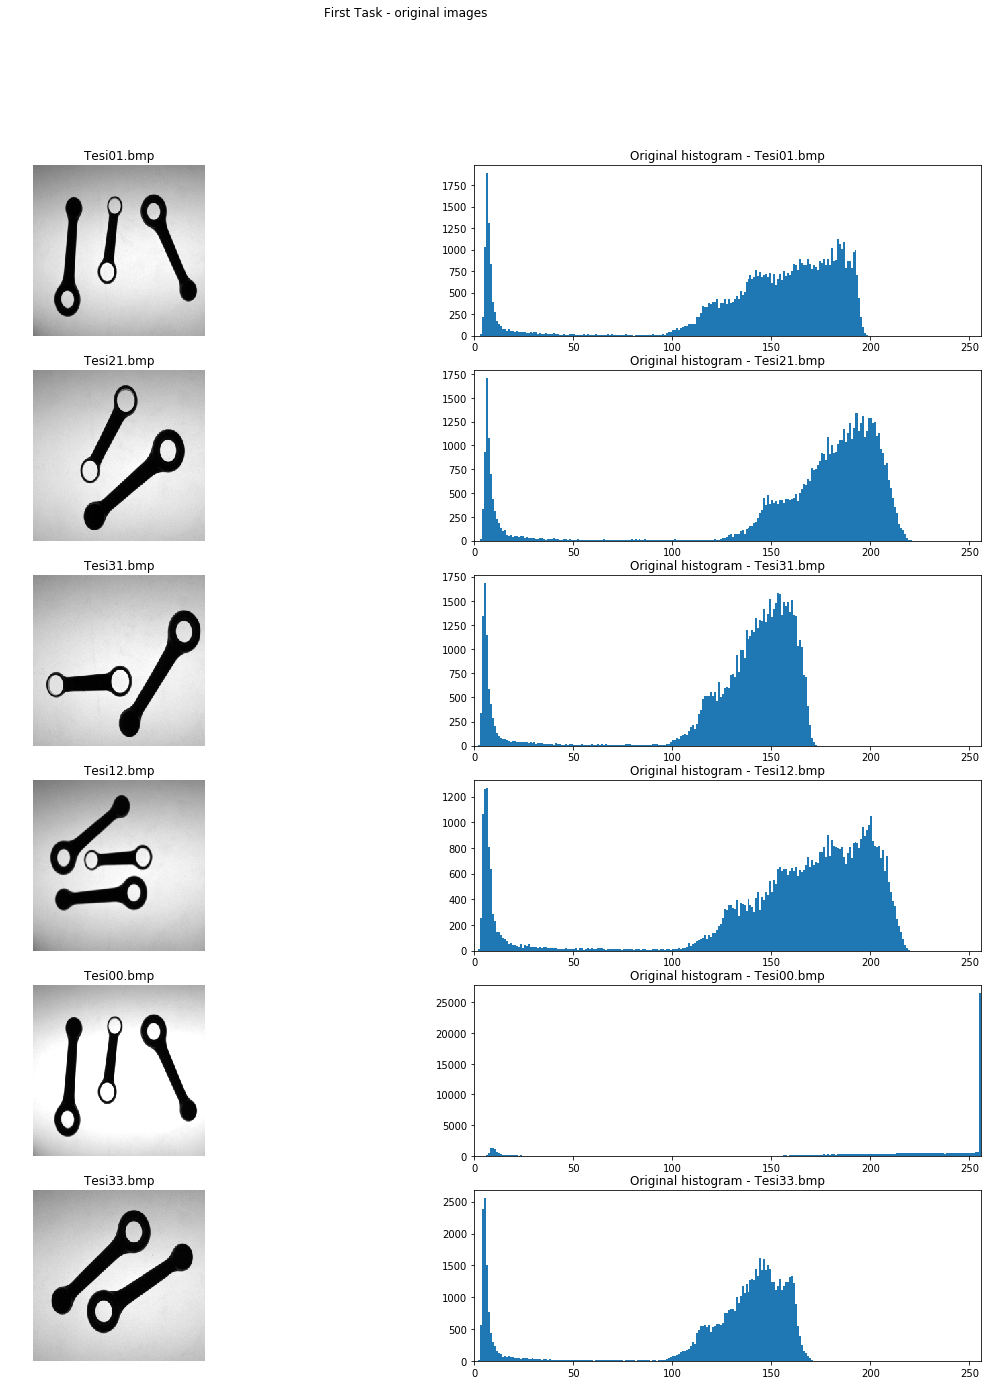

In [3]:
for key in first_task.keys():
    first_task[key] = {"original" : load_image(folder_path, key)}

fig, axs = plt.subplots(nrows=len(first_task), ncols=2, figsize=(20, 22))
fig.suptitle('First Task - original images')
for i, key in enumerate(first_task.keys()):
    # plot original image
    axs[i, 0].imshow(first_task[key]["original"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(key)

    # plot histogram
    axs[i, 1].set_xlim([0,256])
    axs[i, 1].hist(first_task[key]["original"].ravel(), 256, [0, 256])
    axs[i, 1].set_title("Original histogram - " + key) 

plt.show()

Before thresholding, let's apply a local operator like Bilateral filter denoise the image and keep shap edges.

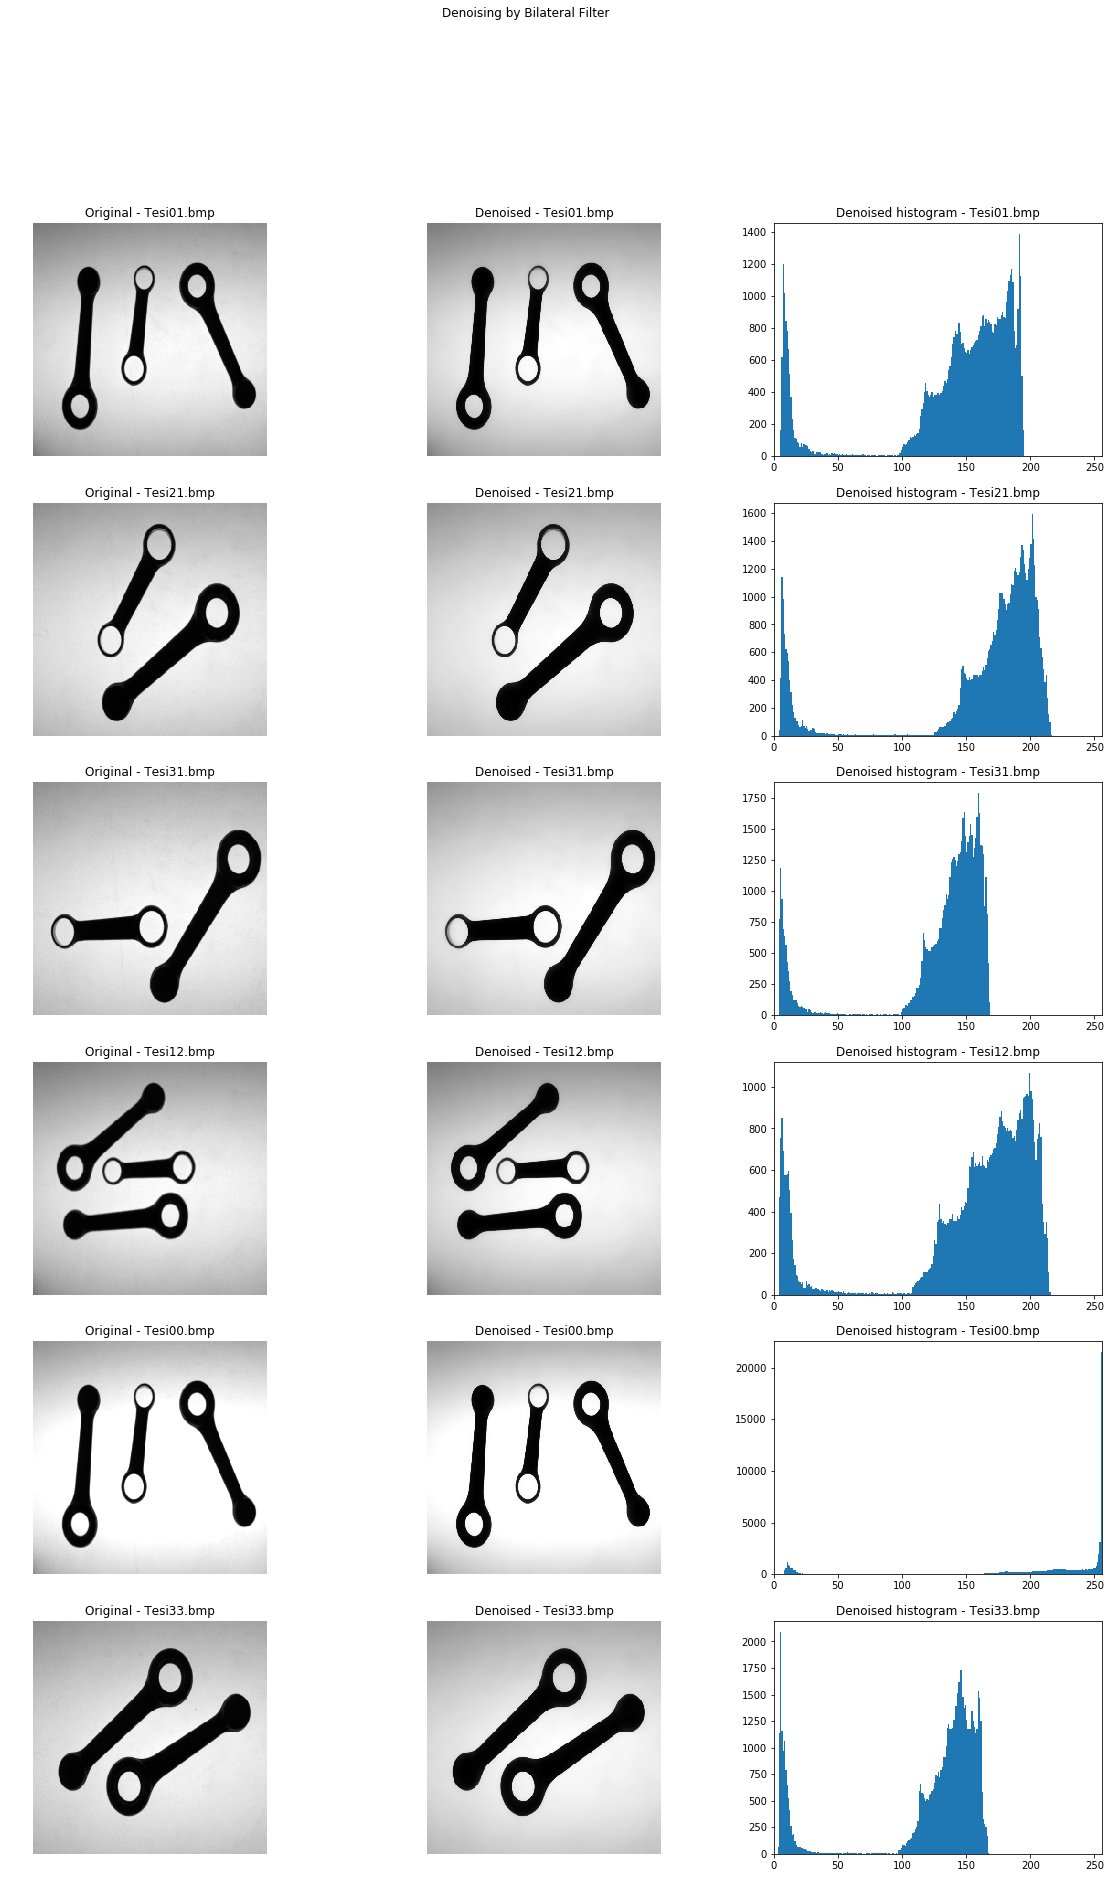

In [4]:
fig, axs = plt.subplots(nrows=len(first_task), ncols=3, figsize=(20, 30))
fig.suptitle('Denoising by Bilateral Filter')
for i, key in enumerate(first_task.keys()):
    # plot original image
    axs[i, 0].imshow(first_task[key]["original"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original - " + key)

    # plot images after bilateral filter
    first_task[key]["denoised"] = cv2.bilateralFilter(first_task[key]["original"], d=19, sigmaColor=45, sigmaSpace=3)
    axs[i, 1].imshow( first_task[key]["denoised"], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Denoised - " + key)

    # plot histogram of images after  bilateral filter
    axs[i, 2].set_xlim([0,256])
    axs[i, 2].hist( first_task[key]["denoised"].ravel(), 256, [0, 256])
    axs[i, 2].set_title("Denoised histogram - " + key)

plt.show()

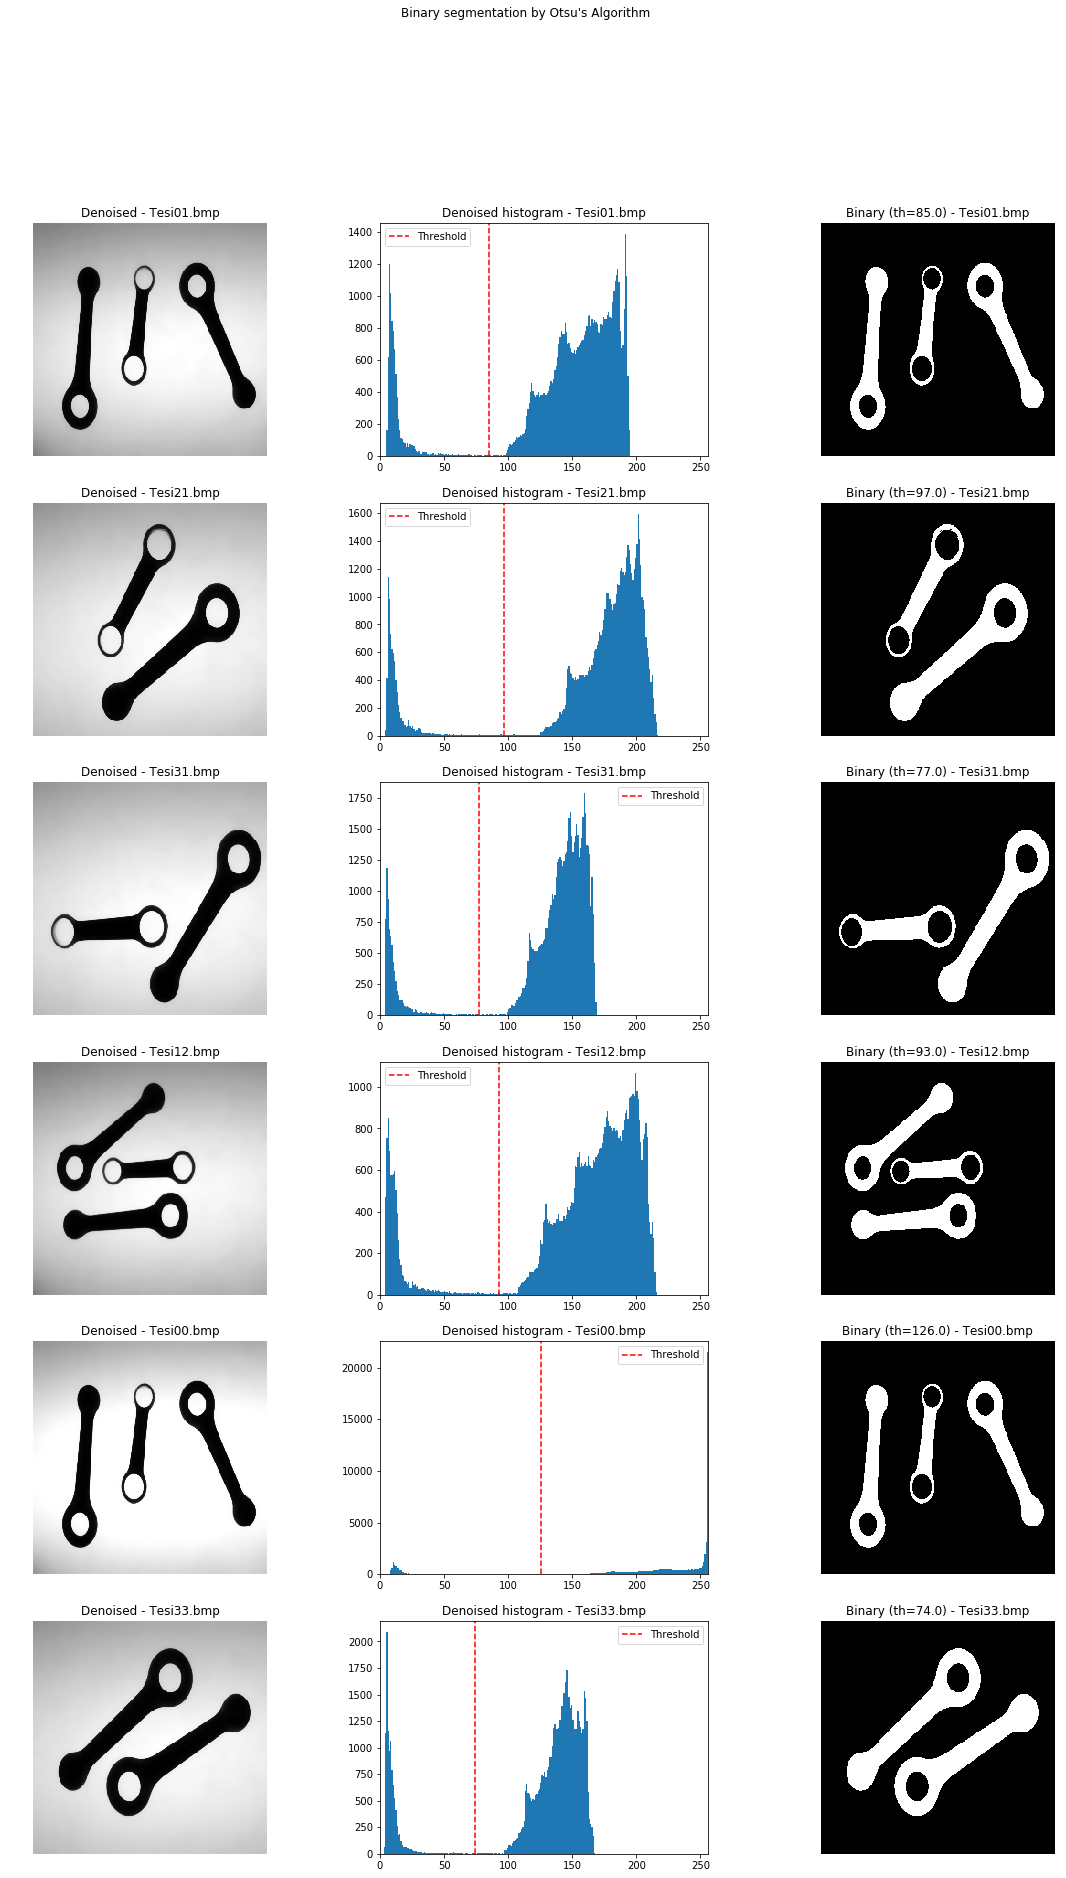

In [5]:
fig, axs = plt.subplots(nrows=len(first_task), ncols=3, figsize=(20, 30))
fig.suptitle("Binary segmentation by Otsu's Algorithm")
for i, key in enumerate(first_task.keys()):
    # plot denoised image
    axs[i, 0].imshow(first_task[key]["denoised"], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Denoised - " + key)

    # plot histogram of images after bilateral filter
    axs[i, 1].set_xlim([0,256])
    axs[i, 1].hist(first_task[key]["denoised"].ravel(), 256, [0, 256])
    axs[i, 1].set_title("Denoised histogram - " + key)

    # plot images after segmentation
    threshold, binary_img = cv2.threshold(first_task[key]["denoised"], 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    first_task[key]["binary"] = binary_img
    axs[i, 1].axvline(x=threshold, color='r',linestyle='--', label='Threshold')
    axs[i, 1].legend(loc='best')
    axs[i, 2].imshow(first_task[key]["binary"], cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title("Binary (th="+str(threshold)+") - " + key)

Then, we proceed with a connected component analysis:

In [6]:
def connected_componentets_analysis(img, connectivity=8, area_threshold=100):
    """
    Compute the number of connected components in the image

    Parameters
    ----------
    img : numpy.ndarray
        Binary image
    connectivity : int, optional
        Connectivity of the connected components. The default is 8.
    area_threshold : int, optional
        Area threshold to filter connected components. The default is 100.
    """
    n_labels, label_ids, stats, centroid = cv2.connectedComponentsWithStats(img, connectivity=connectivity)
            
    for i in range(1, n_labels):
        # Area of the component
        area = stats[i, cv2.CC_STAT_AREA]

        if (area < area_threshold):
            # remove the components that are smaller than the threshold
            np.delete(stats, i)
            np.delete(centroid, i)
            label_ids[label_ids == i] = 0
            n_labels -= 1
    return n_labels, label_ids, stats, centroid


def show_blobs(n_labels, label_ids, stats, centroid, bbox_color=5):
    """
    Show the blobs in the image
    """
    output = np.zeros(label_ids.shape, dtype="uint8")
    for i in range(1, n_labels):
        # stores all the IDs of the components on the each pixel that has the same dimension as the threshold
            output[label_ids == i] = i

            # Now extract the coordinate points
            x1 = stats[i, cv2.CC_STAT_LEFT]
            y1 = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]

            # draw bounding box and centroid
            cv2.rectangle(output, (x1, y1), (x1+w, y1+h), bbox_color, 1) 
            cv2.circle(output, (int(centroid[i][0]), int(centroid[i][1])), 4, bbox_color, -1)
    return output

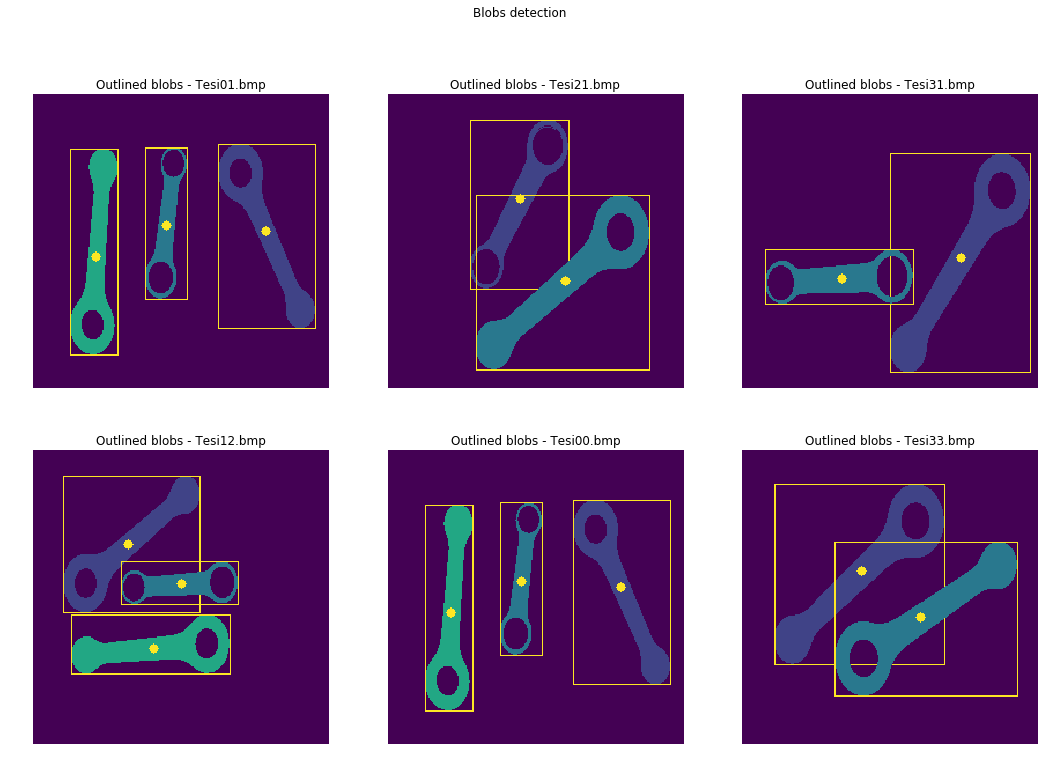

In [7]:
nrows=int(np.ceil(len(first_task)/3))
ncols=3
area_threshold = 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
fig.suptitle("Blobs detection")
for n in range(nrows):
    for m in range(ncols):
        k = n*ncols + m
        if k < len(first_task):
            # perform connected components analysis
            key = list(first_task.keys())[k]
            n_labels, label_ids, stats, centroid = connected_componentets_analysis(first_task[key]["binary"], area_threshold=area_threshold)
            
            # store the results
            first_task[key]["blobs"] = {"n_labels": n_labels, "label_ids": label_ids, "stats": stats, "centroid": centroid}

            # highlight blobs
            output = show_blobs(**first_task[key]["blobs"])
            
            # plot connected components
            axs[n, m].imshow(output)
            axs[n, m].axis('off')
            axs[n, m].set_title("Outlined blobs - " + key)

For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B);
2. Position and orientation modulo $\pi$;
3. Length $L$, width $W$, width at the barycenter $W_b$;
4. For each hole, position of the centre and diameter size.

In [18]:
def get_blob(ids, label):
    """
    Get the blob with the given label

    Parameters
    ----------
    ids : numpy.ndarray
        Image with the labels of the connected components
    label : int
        Label of the blob to be extracted

    Returns
    -------
    numpy.ndarray
        Binary image with the blob

    """
    blob = np.zeros(ids.shape, dtype=np.uint8)
    blob = np.where(ids == label, 1, 0)
    return blob

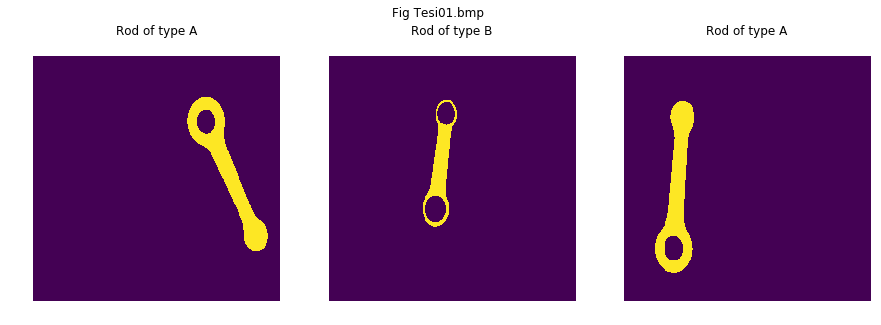

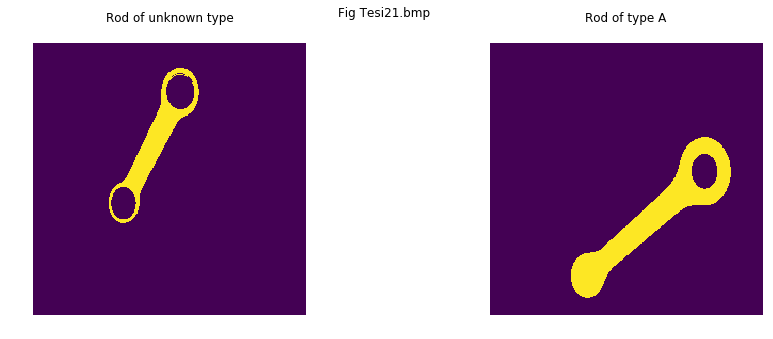

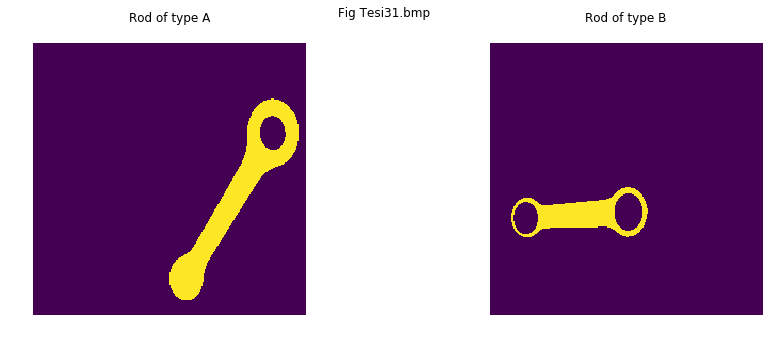

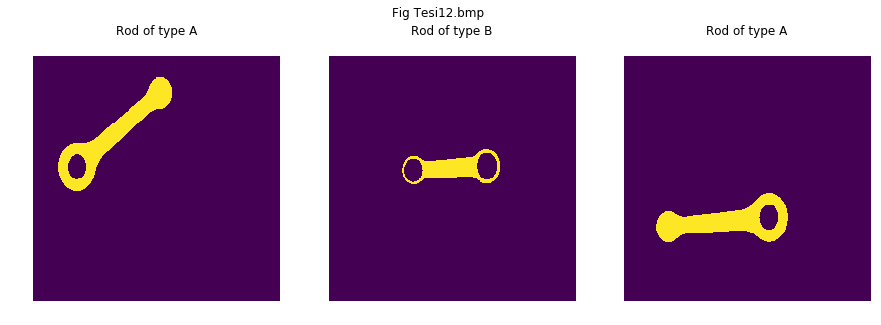

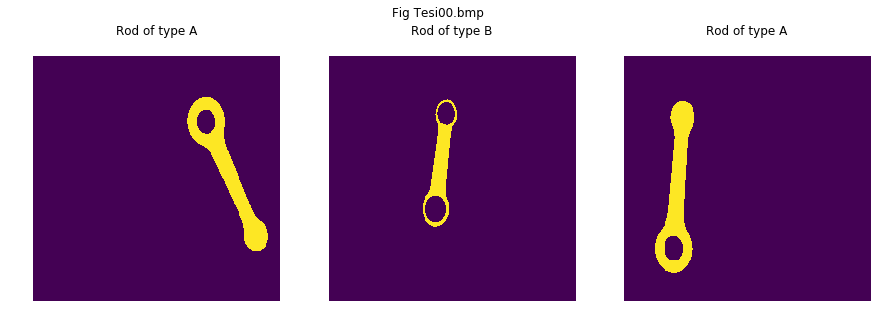

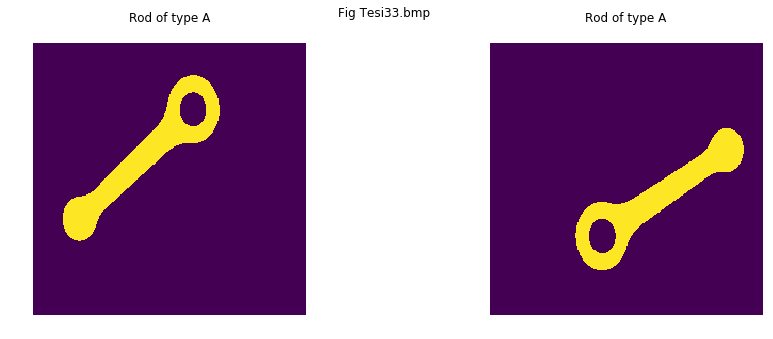

In [22]:
for key in first_task.keys():
    n_labels = first_task[key]["blobs"]["n_labels"]
    labels_ids = first_task[key]["blobs"]["label_ids"]
    stats = first_task[key]["blobs"]["stats"]

    fig, axs = plt.subplots(nrows=1, ncols=n_labels-1, figsize=(15, 5))
    fig.suptitle("Fig "+key)
    for i in range(1, n_labels):
        blob = get_blob(labels_ids, i)

        # compute euler number to classify the type of the rod
        euler = int(mahotas.euler(blob))

        title = ""

        if euler == 0:
            # rod is of type A
            title+="Rod of type A\n"
        elif euler == -1:
            # rod is of type B
            title+="Rod of type B\n"
        else:
            # rod is unknown type
            title+="Rod of unknown type\n"

        # plot the blob
        axs[i-1].imshow(blob)
        axs[i-1].axis('off')
        axs[i-1].set_title(title)